<a href="https://colab.research.google.com/github/L40S38/GAT_practice/blob/main/gat_node_classification_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph attention network (GAT) for node classification

このソースコードは[Graph attention network (GAT) for node classification](https://keras.io/examples/graph/gat_node_classification/)を日本語に翻訳およびGANやGCNの説明を追加したものである。

## Introduction

[グラフ・ニューラル・ネットワーク](https://en.wikipedia.org/wiki/Graph_neural_network)は、グラフとして構造化されたデータ（例えば、ソーシャルネットワークや分子構造）を処理するのに適したニューラルネットワークアーキテクチャであり,完全連結ネットワークや畳み込みネットワークよりも良い結果をもたらす。

このチュートリアルでは、[Graph Attention Network](https://arxiv.org/abs/1710.10903) (GAT)として知られる特定のグラフ・ニューラル・ネットワークを実装し、[Cora](https://linqs.soe.ucsc.edu/data)データセットを使ってどのような種類の論文が引用されているかに基づいて科学論文のラベルを予測する。

### References

GATの詳細については、原著論文[Graph Attention Networks](https://arxiv.org/abs/1710.10903)および[DGL's Graph Attention Networks](https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/9_gat.html)のドキュメントを参照のこと。

### Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

## データセットの取得

 [Cora dataset](https://linqs.soe.ucsc.edu/data)の準備は[Node classification with Graph Neural Networks](https://keras.io/examples/graph/gnn_citations/) チュートリアルを参考にしている. データセットと探索的データ分析の詳細については,このチュートリアルを参照。

簡単に言えば、Cora datasetには2つのファイルが含まれている。
- `cora.cites` 論文間の直接引用関係を示している。
- `cora.content` 論文の特徴(term_n)と論文のラベル(subject)が含まれる。

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

168052/168052 [==============================] - 0s 1us/step


In [3]:
zip_file,data_dir

('/root/.keras/datasets/cora.tgz', '/root/.keras/datasets/cora')

In [4]:
citations

,target,source
0,35,1033
1,35,103482
2,35,103515
...,...,...
5426,853118,1140289
5427,853155,853118
5428,954315,1155073


In [5]:
papers

,paper_id,term_0,term_1,...,term_1431,term_1432,subject
0,31336,0,0,...,0,0,Neural_Networks
1,1061127,0,0,...,0,0,Rule_Learning
2,1106406,0,0,...,0,0,Reinforcement_Learning
...,...,...,...,...,...,...,...
2705,1128978,0,0,...,0,0,Genetic_Algorithms
2706,117328,0,0,...,0,0,Case_Based
2707,24043,0,0,...,0,0,Neural_Networks


In [6]:
# subjectのナンバリング
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
# paperのリナンバリング
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}
class_idx,paper_idx

({'Case_Based': 0,
  'Genetic_Algorithms': 1,
  'Neural_Networks': 2,
  'Probabilistic_Methods': 3,
  'Reinforcement_Learning': 4,
  'Rule_Learning': 5,
  'Theory': 6},
 {35: 0,
  40: 1,
  114: 2,
  117: 3,
  128: 4,
  130: 5,
  164: 6,
  288: 7,
  424: 8,
  434: 9,
  463: 10,
  504: 11,
  506: 12,
  887: 13,
  906: 14,
  910: 15,
  936: 16,
  940: 17,
  941: 18,
  943: 19,
  1026: 20,
  1033: 21,
  1034: 22,
  1035: 23,
  1213: 24,
  1237: 25,
  1246: 26,
  1272: 27,
  1365: 28,
  1385: 29,
  1481: 30,
  1688: 31,
  1694: 32,
  1717: 33,
  1786: 34,
  1817: 35,
  1919: 36,
  1949: 37,
  1951: 38,
  1952: 39,
  1953: 40,
  1955: 41,
  1956: 42,
  1959: 43,
  1997: 44,
  1999: 45,
  2354: 46,
  2440: 47,
  2653: 48,
  2654: 49,
  2658: 50,
  2663: 51,
  2665: 52,
  2695: 53,
  2696: 54,
  2698: 55,
  2702: 56,
  3084: 57,
  3085: 58,
  3095: 59,
  3097: 60,
  3101: 61,
  3112: 62,
  3187: 63,
  3191: 64,
  3192: 65,
  3217: 66,
  3218: 67,
  3220: 68,
  3222: 69,
  3223: 70,
  3229: 71,

In [7]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

リナンバリングされた結果が以下

In [8]:
citations

,target,source
0,0,21
1,0,905
2,0,906
...,...,...
5426,1874,2586
5427,1876,1874
5428,1897,2707


In [9]:
papers

,paper_id,term_0,term_1,...,term_1431,term_1432,subject
0,462,0,0,...,0,0,2
1,1911,0,0,...,0,0,5
2,2002,0,0,...,0,0,4
...,...,...,...,...,...,...,...
2705,2372,0,0,...,0,0,1
2706,955,0,0,...,0,0,0
2707,376,0,0,...,0,0,2


### データセットの分割

In [10]:
#@title ランダムインデックスの取得
#@markdown paperをリナンバリングしたidをランダムに並び替えたものを出力
random_indices = np.random.permutation(range(papers.shape[0]))
random_indices

array([1415,  839,  157, ..., 1608, 2541, 2575])

In [11]:
#@markdown 学習と評価を半分ずつで分割する
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

### グラフデータの準備

In [12]:
# ノードの状態を収集するために使用される論文のidを取得する
# 後でモデルを学習する際にグラフから収集するために使用される。
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()
train_indices, test_indices

(array([2226, 1578,  379, ...,  954, 1463, 1589]),
 array([1597, 1217, 2051, ...,  158, 1480, 1688]))

In [13]:
# それぞれの論文idに対応するground truthラベルを取得する。
# 対応する論文について7つのラベルのうちどれが選ばれているのかを示すリスト
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()
train_labels, test_labels

(array([3, 2, 6, ..., 1, 2, 1]), array([3, 1, 6, ..., 3, 1, 3]))

In [14]:
# データからエッジ特徴量とノード特徴量を抽出
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

In [15]:
# グラフの形状を出力
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape:		 (5429, 2)
Node features shape: (2708, 1433)


つまり、このグラフは5429のエッジと2708個のノードから構成されており、各ノードは1433次元のベクトル特徴量を持っている。

## モデルの構築

GATはグラフ（すなわちエッジテンソルとノード特徴テンソル）を入力とし、ノードの状態を出力する。ノードの状態は、各ノードについて*N*ホップの近傍集約情報である（*N*はGATの層数で決まる）。

重要なことは、[graph convolutional network](https://arxiv.org/abs/1609.02907)(GCN)とは対照的に、GATは隣接ノード(*ソースノード*)からの情報を集約するためにアテンション・マカニズムを利用することである。つまり、ソースノード（*ソース論文*）からターゲットノード（*ターゲット論文*）までのノード状態を単純に平均化／合計するのではなく、GATはまず各ソースノード状態に正規化されたアテンションスコアを適用し、それから合計する。

### GCN



Reference:[【深層学習】GCN(グラフ畳み込みネットワーク)をわかりやすく解説する](https://disassemble-channel.com/deep-learning-gcn/)

In [16]:
from PIL import Image
import io
import requests

# 画像を表示するための関数
def show_image_url(url):
  img = Image.open(io.BytesIO(requests.get(url).content))
  return img

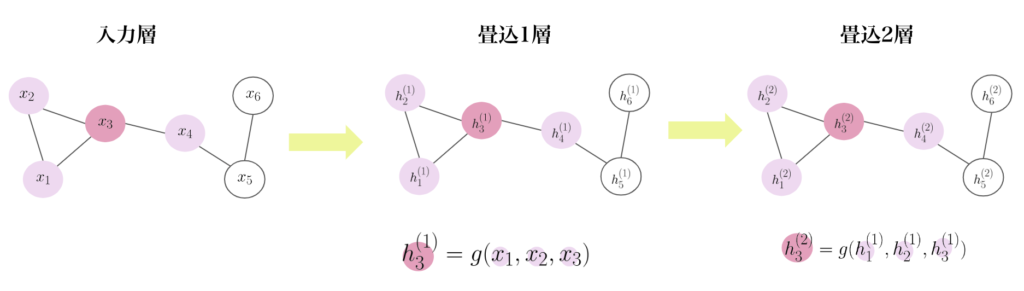

In [17]:
#@title GCNの全体像の流れ
#@markdown 毎回畳み込むごとにノードの特徴量が変化していく
url = 'https://disassemble-channel.com/wp-content/uploads/2022/11/graph_conv_flow-1024x291.png'
show_image_url(url)

ノード特徴量が初めは$\boldsymbol{x}_n$だったのが、$k$回畳み込むと$\boldsymbol{h}_n^{(k)}$になる。

$i$番目のノードに隣接するノードの集合を$N(i)$とすると、$i$番目のノードの特徴量は、$N(i)$に含まれるノードの特徴量を用いて更新されていく。

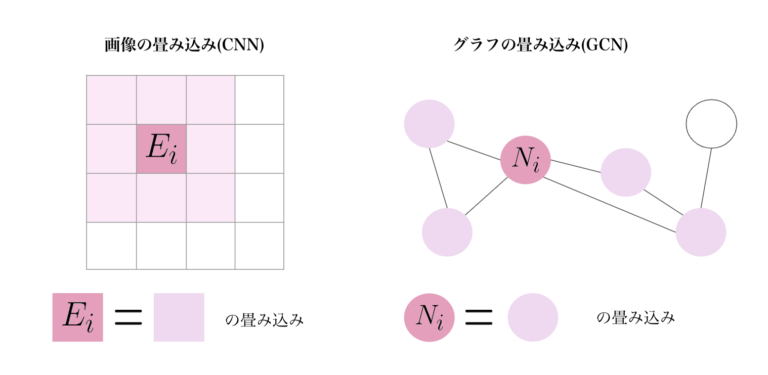

In [18]:
url = 'https://disassemble-channel.com/wp-content/uploads/2022/11/difference_of_cnn_and_gcn-768x375.png'
show_image_url(url)

GCNで解くことのできる問題は主に以下の3つ

- ノード分類
- グラフ分類
- リンク予測

#### GATはGCNとどこが違うのか？

Reference:[【深層学習】Graph Attention Networks(GAT)を理解する](https://disassemble-channel.com/graph-attention-network-gat/)

簡単に言えば、GATはGCNにAttentionの機構を取り入れたものである。

通常のGCNでは、隣接ノードをどれも対等に扱っていたが、GATでは重要度がエッジによって異なる。

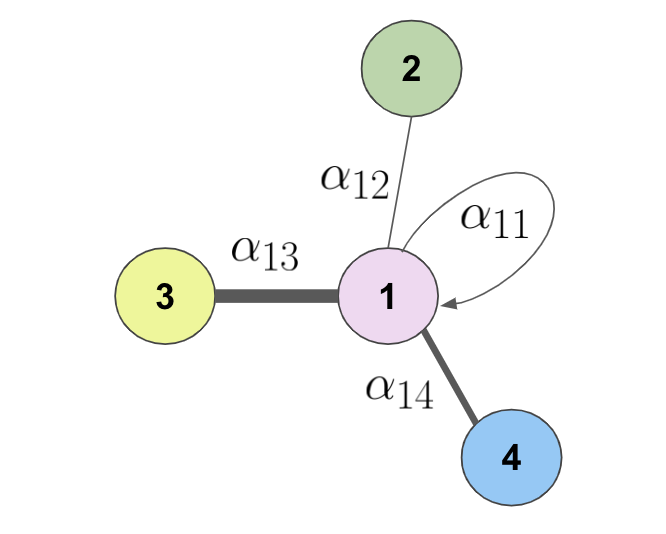

In [19]:
#@markdown 以下の図はノード1に注目した場合の図である。ノード3、ノード4、ノード2の順で重要度が強いときに、重要度を$\alpha$、つまりAttention coreとして導入する。
#@markdown ここで、隣接ノードだけではなく自分自身のノード重要度（$\alpha_{11}$）も考える。
url = "https://disassemble-channel.com/wp-content/uploads/2022/11/self-attention.png"
show_image_url(url)

$e_{ij}=a(Wh_i,Wh_j)$

$\alpha_{ij}=softmax_j(e_{ij})=\frac{exp(e_{ij})}{\sum_{k \in N_i}exp(e_{ik})}$

### (Multi-head) グラフアテンション層

GATモデルではmulti-headのグラフアテンション層が実装されている。

`MultiHeadGraphAttention`層では単に複数のグラフアテンション層(`GraphAttention`)を単に連結(もしくは平均化)したもので、それぞれが独立した学習可能な重み`W`を持っている。

In [20]:
class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # それぞれのAttention headから出力を取得
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # それぞれのAttention headからの出力を連結もしくは平均化する。
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # 活性化して新しいノード特徴量を返す
        return tf.nn.relu(outputs)

`GraphAttention`層は以下のことを行っている。

ノード特徴量$h^{l}$が$W^{l}$によって線形変換され, $z^{l}$を導出することを目指し、それぞれのノードにおいて以下のような処理を行う。

$z^{l}_j = W^{l}h^{l}_j$

1. ペアワイズアテンションスコア $a(z^{l}_{i} || z^{l}_{j})$ をそれぞれの$j$に関して計算し,$e_{ij}$とする.ここで`||` は連結を示しており、, $i$はターゲットノード, $j$は1-hop(1つ隣)の隣接・ソースノードを示している。
2. $e_{ij}$をsoftmax関数で正規化する。 そのため、ターゲットノードへの入力エッジのアテンションスコアの和$\sum_{k} norm({e_{ik}})$は1になる。
3. アテンションスコア$norm({e_{ij}})$を$z_{j}$に加えることで、$h^{{l+1}}_{i}$へとノード特徴量を更新することができる.

- [`tf.gather`](https://www.tensorflow.org/api_docs/python/tf/gather) エッジ経由で隣接ノードの特徴量を取得している
- [`tf.clip_by_value`](https://www.tensorflow.org/api_docs/python/tf/clip_by_value?hl=en) 最小値と最大値を定め、最小値より小さい値は最小値に、最大値より大きい値は最大値に設定
- [`tf.math.unsorted_segment_sum`](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum?hl=en) 引数のsegment_idに応じて要素を配列に追加できる

In [32]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs
        print(f"node_states.shape:{node_states.shape},edges.shape:{edges.shape}")

        # ノード特徴量を線形変換
        node_states_transformed = tf.matmul(node_states, self.kernel)
        print(f"node_states_transformed.shape:{node_states_transformed.shape}")

        # (1) ペアワイズアテンションスコアを計算する
        node_states_expanded = tf.gather(node_states_transformed, edges)
        print(f"node_states_expanded.shape:{node_states_expanded.shape}")
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)
        print(f"attention_scores.shape:{attention_scores.shape}")

        # (2) アテンションスコアの正規化
        # [-2,2]の範囲でクリッピングして指数関数に通す
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        #隣接しているアテンションスコアの和を計算する
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        print(f"attention_scores_sum v1:{attention_scores_sum}")
        #正規化する
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        print(f"attention_scores_sum v2:{attention_scores_sum}")
        attention_scores_norm = attention_scores / attention_scores_sum
        print(f"attention_scores_norm.shape:{attention_scores_norm.shape}")

        # (3) 隣接ノードの状態を収集し、アテンションスコアを適用してノード特徴量を更新
        #隣接ノードの特徴量を収集
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        print(f"node_states_neighbors.shape:{node_states_neighbors.shape}")
        #アテンションスコアを用いてターゲットノードの特徴量を更新する。
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        print(f"out.shape:{out.shape}")
        return out

### カスタム関数 `train_step`, `test_step`, and `predict_step` を用いてアルゴリズムを実装

GATモデルでは学習、検証、テストの全てのフェーズにおいてグラフ全体（`node_states`と`edges`）が操作される。したがって、`node_states`と`edges`はそれぞれ`keras.Model`のコンストラクタに渡されattributeとして使用される。
違いは収集するデータのインデックスである。 (`tf.gather(outputs, indices)`).

In [22]:

class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # フォワードパッシング
            outputs = self([self.node_states, self.edges])
            # 損失の計算
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # 勾配の計算
        grads = tape.gradient(loss, self.trainable_weights)
        # 重みの更新
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # 状態の更新
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # 予測値の計算
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # フォワードパッシング
        outputs = self([self.node_states, self.edges])
        # 損失の計算
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # 状態の更新
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


### Train and evaluate

In [33]:
# ハイパーパラメータの定義
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# モデルの構築
gat_model = GraphAttentionNetwork(
    node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

# モデルのコンパイル
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

Epoch 1/100
node_states.shape:(2708, 800),edges.shape:(5429, 2)
node_states_transformed.shape:(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_sum v1:Tensor("graph_attention_network_4/multi_head_graph_attention_12/graph_attention_96/UnsortedSegmentSum:0", shape=(None,), dtype=float32)
attention_scores_sum v2:Tensor("graph_attention_network_4/multi_head_graph_attention_12/graph_attention_96/Repeat/boolean_mask/GatherV2:0", shape=(None,), dtype=float32)
attention_scores_norm.shape:(5429,)
node_states_neighbors.shape:(5429, 100)
out.shape:(2708, 100)
node_states.shape:(2708, 800),edges.shape:(5429, 2)
node_states_transformed.shape:(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_sum v1:Tensor("graph_attention_network_4/multi_head_graph_attention_12/graph_attention_97/UnsortedSegmentSum:0", shape=(None,), dtype=float32)
attention_scores_sum v2:Tensor("graph_attention_network_4/multi_he

### gat_modelの描画

Model: "graph_attention_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1147200   
                                                                 
 multi_head_graph_attention   multiple                 641600    
 (MultiHeadGraphAttention)                                       
                                                                 
 multi_head_graph_attention_  multiple                 641600    
 1 (MultiHeadGraphAttention)                                     
                                                                 
 multi_head_graph_attention_  multiple                 641600    
 2 (MultiHeadGraphAttention)                                     
                                                                 
 dense_1 (Dense)             multiple                  5607      
                                           

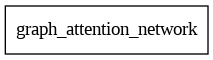

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

#summary()で可視化
print(gat_model.summary())

#グラフで可視化。
plot_model(gat_model, show_shapes=True)

### ノードのラベル予測

In [25]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

node_states.shape:(2708, 800),edges.shape:(5429, 2)
(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_norm.shape:(5429,)
out.shape:(2708, 100)
node_states.shape:(2708, 800),edges.shape:(5429, 2)
(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_norm.shape:(5429,)
out.shape:(2708, 100)
node_states.shape:(2708, 800),edges.shape:(5429, 2)
(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_norm.shape:(5429,)
out.shape:(2708, 100)
node_states.shape:(2708, 800),edges.shape:(5429, 2)
(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_norm.shape:(5429,)
out.shape:(2708, 100)
node_states.shape:(2708, 800),edges.shape:(5429, 2)
(2708, 100)
node_states_expanded.shape:(5429, 2, 100)
attention_scores.shape:(5429,)
attention_scores_norm.shape:(5429,)
out.shape:(2708, 100)
node_states.shape:(2708, 

## Conclusions

結果は問題なく、GATモデルは論文の主題を約80％の確率で引用文献から論文の主題を正しく予測しているようだ。GATのハイパーパラメーターを微調整することで
GATのハイパーパラメータをファインチューニングすることでさらに改善できる。
例えば
- レイヤーの数を変えてみる
- 正則化（ドロップアウトなど）を追加する
- 前処理ステップを変更する。
を試みることもできる。

また、*自己ループ*の実装(すなわち、論文Xが論文Xを引用するという情報の付与)、及び/又はグラフを*無向グラフ*にすることもできる。